In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

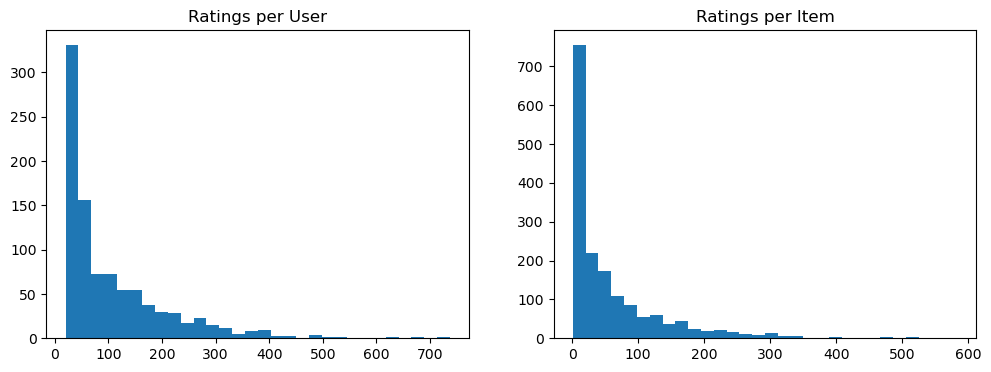

In [2]:
#Ratings data
ratings= pd.read_csv('../data/processed/rating.csv')
ratings.head()

# compute counts
ratings_per_user = ratings.groupby("user_id")["rating"].count()
ratings_per_item = ratings.groupby("item_id")["rating"].count()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ratings_per_user, bins=30)
plt.title("Ratings per User")
plt.subplot(1,2,2)
plt.hist(ratings_per_item, bins=30)
plt.title("Ratings per Item")
plt.show()

In [3]:
users = ratings['user_id'].unique()
items_list = ratings['item_id'].unique()
user_map = {u:i for i,u in enumerate(sorted(users))}
item_map = {i:j for j,i in enumerate(sorted(items_list))}
with open("../models/user_map.pkl","wb") as f:
    pickle.dump(user_map,f)
with open("../models/item_map.pkl","wb") as f:
    pickle.dump(item_map,f)

In [4]:
ratings = ratings.sort_values("timestamp")
train_rows, valid_rows, test_rows = [], [], []
for user, g in ratings.groupby("user_id"):
    g = g.sort_values("timestamp")
    n = len(g)
    if n < 3:
        # if too few interactions, put all in train (or drop user)
        train_rows.append(g)
        continue
    # last -> test, second last -> val
    test = g.iloc[-1:]
    val = g.iloc[-2:-1]
    train = g.iloc[:-2]
    train_rows.append(train); valid_rows.append(val); test_rows.append(test)

train_df = pd.concat(train_rows).reset_index(drop=True)
valid_df = pd.concat(valid_rows).reset_index(drop=True)
test_df = pd.concat(test_rows).reset_index(drop=True)
print("train/val/test sizes:", train_df.shape, valid_df.shape, test_df.shape)
with open("../data/processed/train_valid_test.pkl","wb") as f:
    pickle.dump((train_df, valid_df, test_df), f)

train/val/test sizes: (98114, 4) (943, 4) (943, 4)


In [5]:
import math
def precision_at_k(recommended, true_items, k=10):
    recommended_set = set(recommended[:k])
    true_set = set(true_items)
    return len(recommended_set & true_set) / k

def recall_at_k(recommended, true_items, k=10):
    recommended_set = set(recommended[:k])
    true_set = set(true_items)
    if len(true_set)==0: return 0.0
    return len(recommended_set & true_set) / len(true_set)

def ndcg_at_k(recommended, true_items, k=10):
    recommended = recommended[:k]
    dcg = 0.0
    for i,item in enumerate(recommended):
        if item in true_items:
            dcg += 1.0 / math.log2(i+2)
    ideal_hits = min(len(true_items), k)
    if ideal_hits == 0: return 0.0
    idcg = sum([1.0 / math.log2(i+2) for i in range(ideal_hits)])
    return dcg / idcg

def evaluate_recommender(recommender, val_df, k=10, users=None):
    precisions, recalls, ndcgs = [], [], []
    if users is None:
        users = val_df['user_id'].unique()
    # group true items by user
    true_by_user = val_df.groupby("user_id")["item_id"].apply(list).to_dict()
    for u in users:
        true = true_by_user.get(u, [])
        preds = recommender.recommend(u, k=k)
        precisions.append(precision_at_k(preds, true, k))
        recalls.append(recall_at_k(preds, true, k))
        ndcgs.append(ndcg_at_k(preds, true, k))
    return {"precision@"+str(k):np.mean(precisions),
            "recall@"+str(k):np.mean(recalls),
            "ndcg@"+str(k):np.mean(ndcgs)}

In [6]:
class PopularRecommender:
    def __init__(self, train_df):
        self.popularity = train_df.groupby("item_id")["rating"].count().sort_values(ascending=False)
        self.popular_items = list(self.popularity.index)

    def recommend(self, user_id, k=10):
        # naive: return top-k popular items (could exclude items in user's train)
        return self.popular_items[:k]

# create model and evaluate
pop_model = PopularRecommender(train_df)
metrics_pop = evaluate_recommender(pop_model, valid_df, k=10)
print("Popularity baseline metrics:", metrics_pop)

Popularity baseline metrics: {'precision@10': 0.0042417815482502655, 'recall@10': 0.042417815482502653, 'ndcg@10': 0.0200898934761687}


In [7]:
class PopularExcludeSeen:
    def __init__(self, train_df):
        self.popularity = train_df.groupby("item_id")["rating"].count().sort_values(ascending=False)
        self.popular_items = list(self.popularity.index)
        # build user->seen set
        self.seen = train_df.groupby("user_id")["item_id"].apply(set).to_dict()

    def recommend(self, user_id, k=10):
        seen = self.seen.get(user_id, set())
        res = []
        for item in self.popular_items:
            if item not in seen:
                res.append(item)
            if len(res) >= k:
                break
        return res

pop_ex = PopularExcludeSeen(train_df)
metrics_pop_ex = evaluate_recommender(pop_ex, valid_df, k=10)
print("Popularity excluding seen items metrics:", metrics_pop_ex)

Popularity excluding seen items metrics: {'precision@10': 0.007317073170731708, 'recall@10': 0.07317073170731707, 'ndcg@10': 0.038413565880608694}


In [8]:
with open("../models/popularity_baseline.pkl","wb") as f:
    pickle.dump(pop_ex, f)

# ===== Quick top-10 result for a sample user =====
sample_user = train_df['user_id'].iloc[0]
print("sample user:", sample_user, "recommend:", pop_ex.recommend(sample_user,10))


sample user: 1 recommend: [286, 294, 288, 300, 313, 405, 748, 423, 318, 276]
